In [11]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import xarray

import jax_cfd.base as cfd
import jax_cfd.base.grids as grids
import jax_cfd.spectral as spectral
import numpy as np
import dataclasses

In [36]:
size = 256
density = 1.
viscosity = 1e-3
seed = 0
max_velocity = 2.0


In [37]:
def cfd_data_generation(seed, size, density, viscosity, max_velocity):
    # Define the physical dimensions of the simulation.
    grid = cfd.grids.Grid((size, size), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))

    # Construct a random initial velocity. The `filtered_velocity_field` function
    # ensures that the initial velocity is divergence free and it filters out
    # high frequency fluctuations.
    v0 = cfd.initial_conditions.filtered_velocity_field(
        jax.random.PRNGKey(seed), grid, max_velocity)

    cfl_safety_factor = 0.5
    # Choose a time step.
    dt = cfd.equations.stable_time_step(
        max_velocity, cfl_safety_factor, viscosity, grid)

    # Number of inner and outer steps.
    inner_steps, outer_steps = 25, 200
    # Define a step function and use it to compute a trajectory.
    step_fn = cfd.funcutils.repeated(
        cfd.equations.semi_implicit_navier_stokes(
            density=density, viscosity=viscosity, dt=dt, grid=grid),
        steps=inner_steps)
    rollout_fn = jax.jit(cfd.funcutils.trajectory(step_fn, outer_steps))
    _, trajectory = jax.device_get(rollout_fn(v0))
    return trajectory

In [38]:
raw_data = cfd_data_generation(seed, size, density, viscosity, max_velocity)
u_traj, v_traj = raw_data  # unpack trajectory tuple
# Each is a GridVariable with .data = ndarray of shape (time, nx, ny)
u_array, v_array = u_traj.data, v_traj.data

In [39]:
# Compute vorticity using spectral method
def vorticity_fft(u, v, Lx=2*np.pi, Ly=2*np.pi):
    nx, ny = u.shape[-2], u.shape[-1]
    kx = 2*np.pi*np.fft.fftfreq(nx, d=Lx/nx)
    ky = 2*np.pi*np.fft.fftfreq(ny, d=Ly/ny)
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    u_hat = np.fft.fft2(u)
    v_hat = np.fft.fft2(v)
    dvdx_hat = 1j*KX*v_hat
    dudy_hat = 1j*KY*u_hat
    vort_hat = dvdx_hat - dudy_hat
    return np.real(np.fft.ifft2(vort_hat))

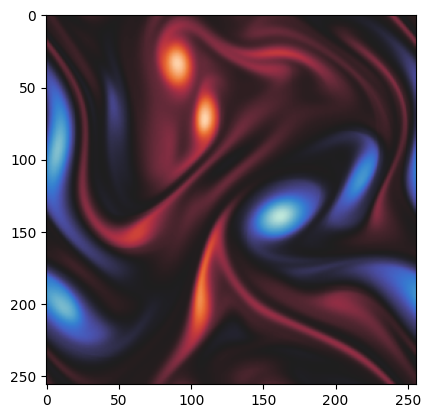

In [40]:
vort_field = vorticity_fft(u_array[100], v_array[100])
plt.imshow(vort_field, cmap=sns.cm.icefire)

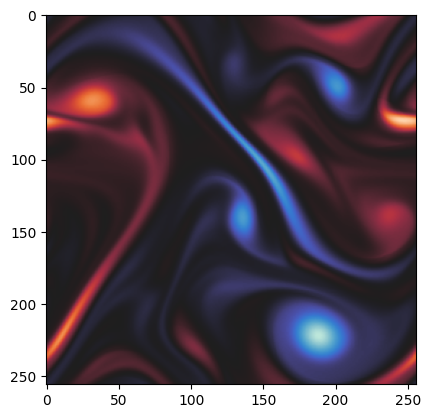

In [41]:
raw_data = cfd_data_generation(42, size, density, viscosity, max_velocity)
u_traj, v_traj = raw_data  # unpack trajectory tuple
# Each is a GridVariable with .data = ndarray of shape (time, nx, ny)
u_array, v_array = u_traj.data, v_traj.data
vort_field = vorticity_fft(u_array[100], v_array[100])
plt.imshow(vort_field, cmap=sns.cm.icefire)

# Inverse Problems

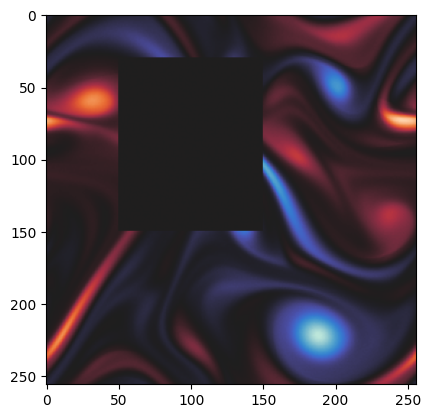

In [70]:
x_gt = vort_field
# ---------------------------
# Create a mask
# ---------------------------
mask = np.ones_like(x_gt, dtype=np.float32)
mask[30:150, 50:150] = 0.0               # mask out a rectangular region

# ---------------------------
# Apply mask and add noise
# ---------------------------
y_masked = mask * x_gt

sigma = 0.01  # standard deviation of Gaussian noise
noise = np.random.normal(0, sigma, x_gt.shape).astype(np.float32)
y = y_masked + noise
plt.imshow(y, cmap=sns.cm.icefire)

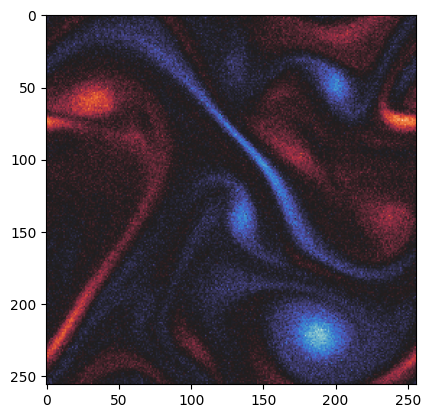

In [94]:
sigma = 0.5
noise = np.random.normal(0, sigma, x_gt.shape).astype(np.float32)
y_noisy = x_gt + noise
plt.imshow(y_noisy, cmap=sns.cm.icefire)


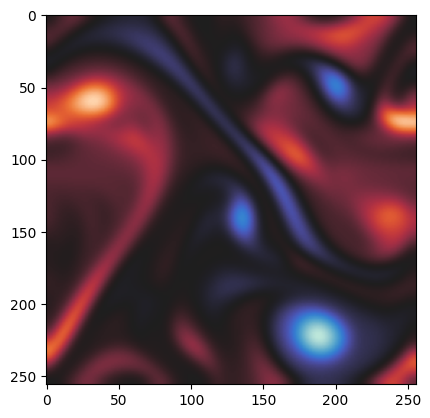

In [92]:
from scipy.ndimage import gaussian_filter
y_blur = gaussian_filter(x_gt, sigma=5.0)
plt.imshow(y_blur, cmap=sns.cm.icefire)


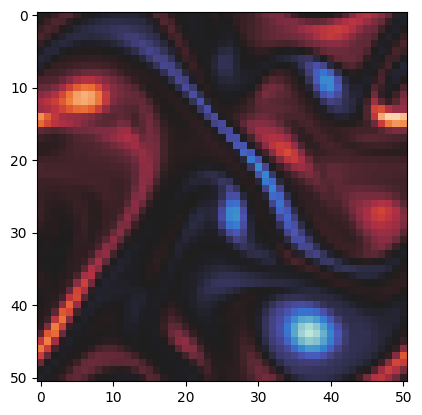

In [388]:
from skimage.transform import resize

scale = 5
y_lowres = resize(x_gt, (x_gt.shape[0]//scale, x_gt.shape[1]//scale), anti_aliasing=True)
y_sr = resize(y_lowres, x_gt.shape, anti_aliasing=False)

plt.imshow(y_lowres, cmap=sns.cm.icefire)


# Physics Pertubation

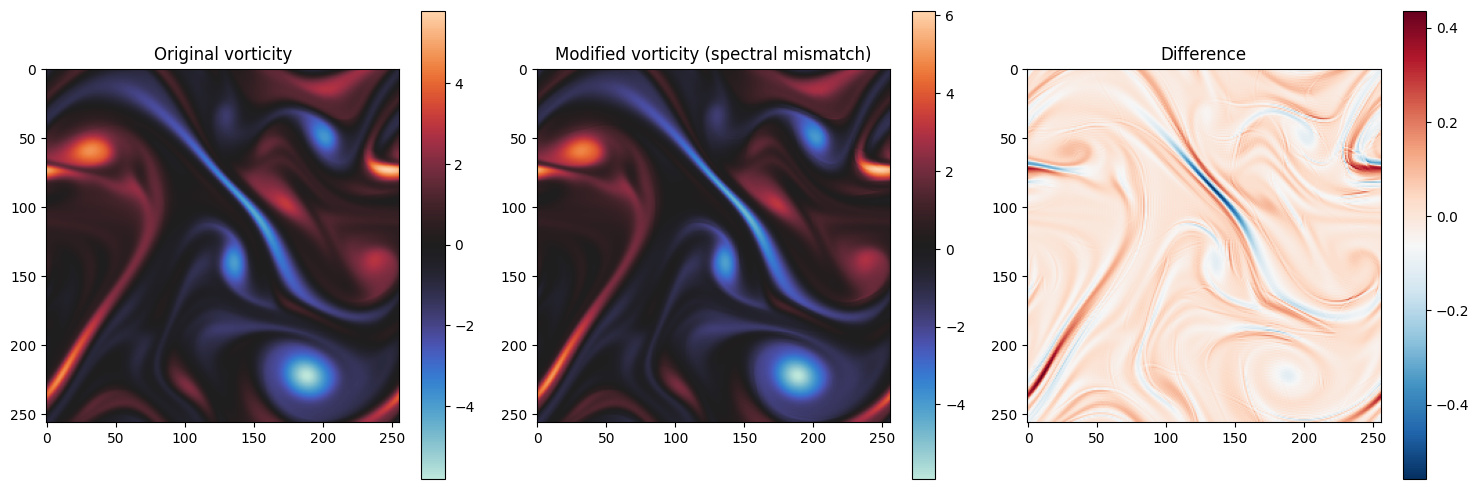

In [150]:
import numpy as np
import matplotlib.pyplot as plt

u_field, v_field = u_array[100], v_array[100]


# Suppose these are your simulated fields (vorticity + velocity)
# shape: (nx, ny)
omega = vort_field      # existing simulated vorticity
u = u_field             # existing velocity x-component
v = v_field             # existing velocity y-component

nx, ny = omega.shape
kx = 2*np.pi*np.fft.fftfreq(nx)
ky = 2*np.pi*np.fft.fftfreq(ny)
KX, KY = np.meshgrid(kx, ky, indexing='ij')
K = np.sqrt(KX**2 + KY**2)

# --- Define spectral mismatch ---
c = 5.0      # strength
alpha = 1.5  # exponent
m = c * (K / (K.max() + 1e-8))**alpha

# Apply it directly to vorticity
omega_hat = np.fft.fft2(omega)
omega_mod_hat = (1 + m) * omega_hat   # can also use m alone if you want only the extra term
omega_mod = np.real(np.fft.ifft2(omega_mod_hat))

# Recompute velocity from modified vorticity
psi_hat = -omega_mod_hat / (K**2 + 1e-12)
u_mod = np.real(np.fft.ifft2(1j*KY*psi_hat))
v_mod = np.real(np.fft.ifft2(-1j*KX*psi_hat))

# Plot
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Original vorticity")
plt.imshow(omega, cmap='icefire'); plt.colorbar()

plt.subplot(1,3,2)
plt.title("Modified vorticity (spectral mismatch)")
plt.imshow(omega_mod, cmap='icefire'); plt.colorbar()

plt.subplot(1,3,3)
plt.title("Difference")
plt.imshow(omega_mod - omega, cmap='RdBu_r'); plt.colorbar()
plt.tight_layout()
plt.show()


In [159]:
import numpy as np
import matplotlib.pyplot as plt

# --- Load one frame from your simulation ---
omega = vort_field            # shape: (nx, ny)
u = u_array[100]
v = v_array[100]

nx, ny = omega.shape

# Fourier grid
kx = 2*np.pi*np.fft.fftfreq(nx)
ky = 2*np.pi*np.fft.fftfreq(ny)
KX, KY = np.meshgrid(kx, ky, indexing='ij')
K = np.sqrt(KX**2 + KY**2)
Kmax = K.max() + 1e-8


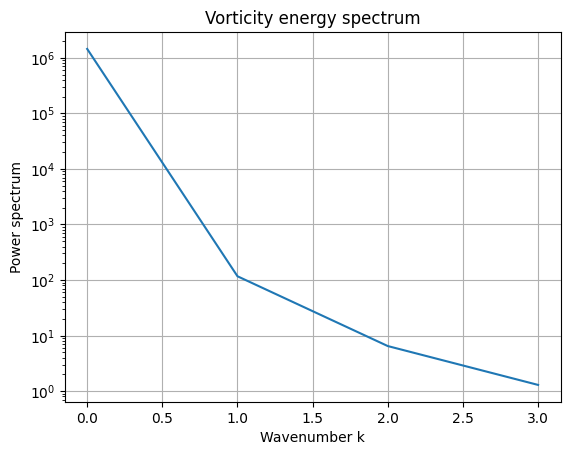

In [160]:
omega_hat = np.fft.fft2(omega)
E_k = np.abs(omega_hat)**2

# Radially average spectrum
K_flat = K.flatten()
E_flat = E_k.flatten()
k_bins = np.arange(0, Kmax, 1)
spectrum, _ = np.histogram(K_flat, bins=k_bins, weights=E_flat)
counts, _ = np.histogram(K_flat, bins=k_bins)
spectrum /= (counts + 1e-12)

plt.figure()
plt.semilogy(k_bins[:-1], spectrum + 1e-20)
plt.xlabel("Wavenumber k")
plt.ylabel("Power spectrum")
plt.title("Vorticity energy spectrum")
plt.grid(True)
plt.show()


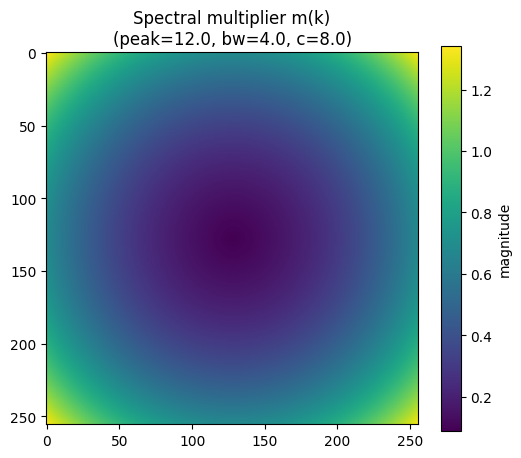

In [170]:
# User controls
peak = 12.0       # where spectrum has real energy
bandwidth = 4.0   # narrow band => sharp effect
c = 8.0           # increase to make it dramatic

# Define band-pass multiplier
m = c * np.exp(-((K - peak)**2) / (2 * bandwidth**2))

# Visualize m(k)
plt.figure(figsize=(6,5))
plt.title(f"Spectral multiplier m(k)\n(peak={peak}, bw={bandwidth}, c={c})")
plt.imshow(np.fft.fftshift(m), cmap='viridis')
plt.colorbar(label='magnitude')
plt.show()


In [171]:
psi_hat = -omega_mod_hat / (K**2 + 1e-12)
u_mod = np.real(np.fft.ifft2(1j*KY*psi_hat))
v_mod = np.real(np.fft.ifft2(-1j*KX*psi_hat))

# Divergence check
div_mod = np.gradient(u_mod, axis=0) + np.gradient(v_mod, axis=1)
print("Divergence stats:", div_mod.mean(), div_mod.std())


Divergence stats: 1.7275236959251455e-18 0.004519656060111136


In [165]:
diff = omega_mod - omega
rel_L2 = np.linalg.norm(diff) / np.linalg.norm(omega)
max_abs = np.max(np.abs(diff))
print(f"Relative L2 difference: {rel_L2:.3e}")
print(f"Max pointwise difference: {max_abs:.3e}")


Relative L2 difference: 8.420e-06
Max pointwise difference: 5.301e-05


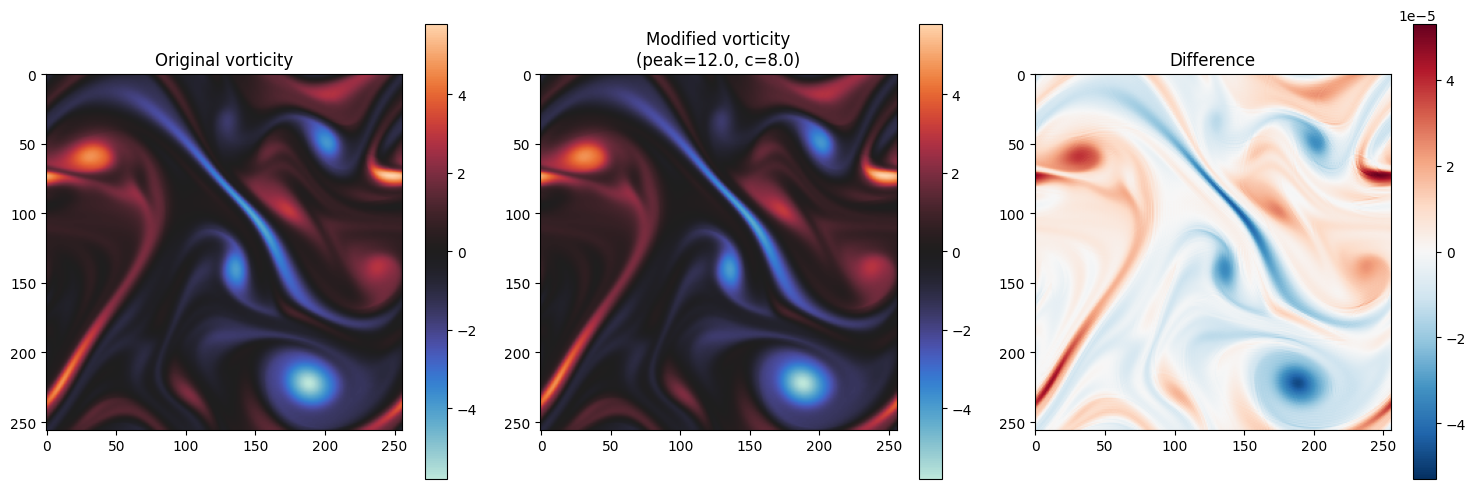

In [172]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Original vorticity")
plt.imshow(omega, cmap='icefire'); plt.colorbar()

plt.subplot(1,3,2)
plt.title(f"Modified vorticity\n(peak={peak}, c={c})")
plt.imshow(omega_mod, cmap='icefire'); plt.colorbar()

plt.subplot(1,3,3)
plt.title("Difference")
plt.imshow(diff, cmap='RdBu_r',
           vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
plt.colorbar()
plt.tight_layout()
plt.show()


[check] Kmax=181.02, spectrum peak around k≈1


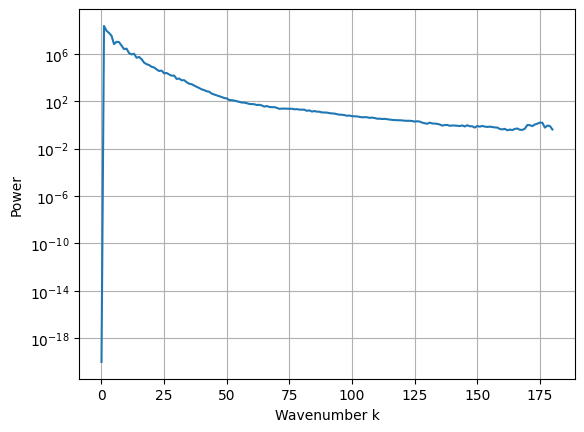

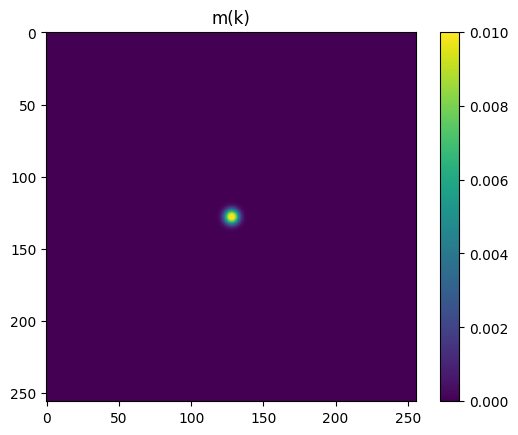

[check] div mean=1.37e-20, std=1.11e-04
[gap]   rel L2=7.294e-03, max|Δ|=3.800e-02


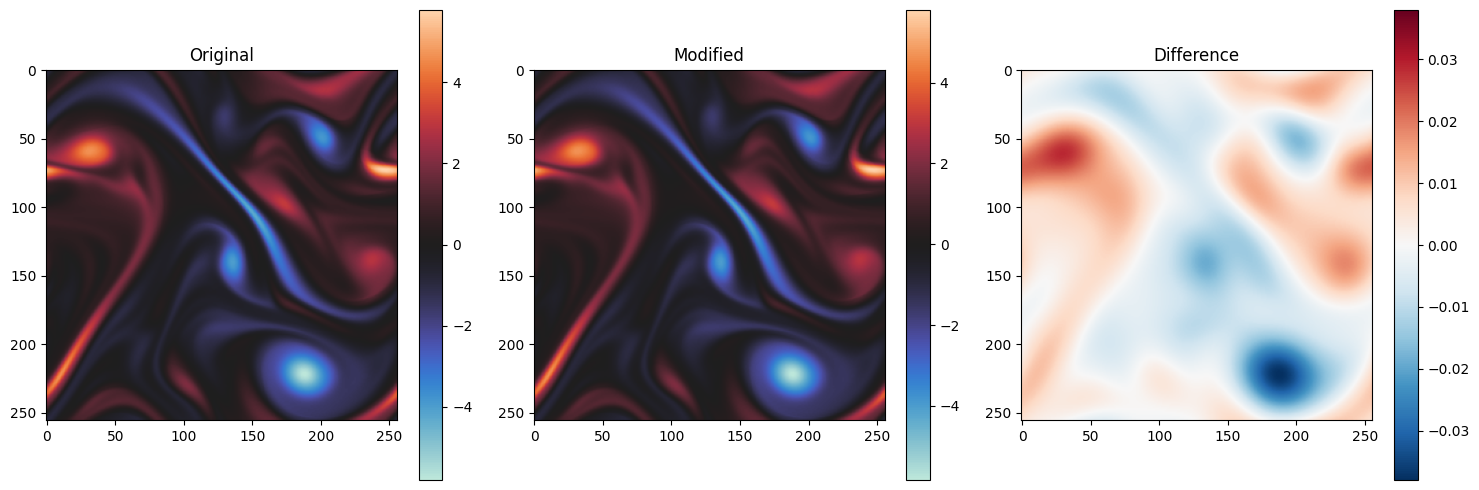

In [175]:
import numpy as np
import matplotlib.pyplot as plt

omega = vort_field
nx, ny = omega.shape
Lx = Ly = 2*np.pi                      # periodic 2π domain (common in CFD)

# Correct k-grid: integer wavenumbers 0..N/2 when L=2π
kx = 2*np.pi * np.fft.fftfreq(nx, d=Lx/nx)
ky = 2*np.pi * np.fft.fftfreq(ny, d=Ly/ny)
KX, KY = np.meshgrid(kx, ky, indexing='ij')
K = np.sqrt(KX**2 + KY**2)
Kmax = K.max()

# --- Inspect spectrum (radial average) to choose a good peak ---
Omega = np.fft.fft2(omega)
P = np.abs(Omega)**2
k_bins = np.arange(0, Kmax, 1.0)                  # integer shells
Kb = K.ravel(); Pb = P.ravel()
spec, _ = np.histogram(Kb, bins=k_bins, weights=Pb)
cnts, _ = np.histogram(Kb, bins=k_bins)
spec = spec / (cnts + 1e-12)

k_vals = k_bins[:-1]
k_peak = k_vals[np.argmax(spec[1:])+1]            # skip k=0
print(f"[check] Kmax={Kmax:.2f}, spectrum peak around k≈{k_peak:.0f}")

plt.figure(); plt.semilogy(k_vals, spec+1e-20); plt.grid(True)
plt.xlabel("Wavenumber k"); plt.ylabel("Power"); plt.show()

# --- Strong band-pass centered where energy actually is ---
peak      = float(k_peak)          # or manually set (e.g., 10–20)
bandwidth = 3.0
c         = 0.01                    # strength; increase for more drama

m = c * np.exp(-((K - peak)**2) / (2*bandwidth**2))
plt.figure(); plt.title("m(k)"); plt.imshow(np.fft.fftshift(m), cmap='viridis'); plt.colorbar(); plt.show()

# Apply operator
Omega_mod = (1 + m) * Omega
omega_mod = np.real(np.fft.ifft2(Omega_mod))

# Recompute u,v (keeps incompressibility)
psi_hat = -Omega_mod / (K**2 + 1e-12)
u_mod = np.real(np.fft.ifft2(1j*KY*psi_hat))
v_mod = np.real(np.fft.ifft2(-1j*KX*psi_hat))

# Diagnostics
div = np.gradient(u_mod, axis=0) + np.gradient(v_mod, axis=1)
diff = omega_mod - omega
print(f"[check] div mean={div.mean():.2e}, std={div.std():.2e}")
print(f"[gap]   rel L2={np.linalg.norm(diff)/np.linalg.norm(omega):.3e}, "
      f"max|Δ|={np.max(np.abs(diff)):.3e}")

# Plots
plt.figure(figsize=(15,5))
for i,(img,title) in enumerate([(omega,"Original"), (omega_mod,"Modified"), (diff,"Difference")],1):
    plt.subplot(1,3,i); plt.title(title)
    vmax = None if i<3 else np.max(np.abs(diff))
    plt.imshow(img, cmap='icefire' if i<3 else 'RdBu_r',
               vmin=(-vmax if vmax is not None else None),
               vmax=(vmax if vmax is not None else None))
    plt.colorbar()
plt.tight_layout(); plt.show()


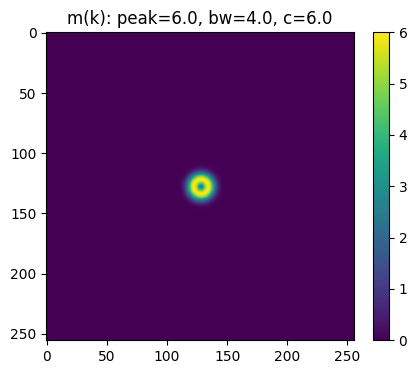

div mean=6.73e-19, std=2.73e-03
rel L2=2.947e+01, max|Δ|=1.618e+02


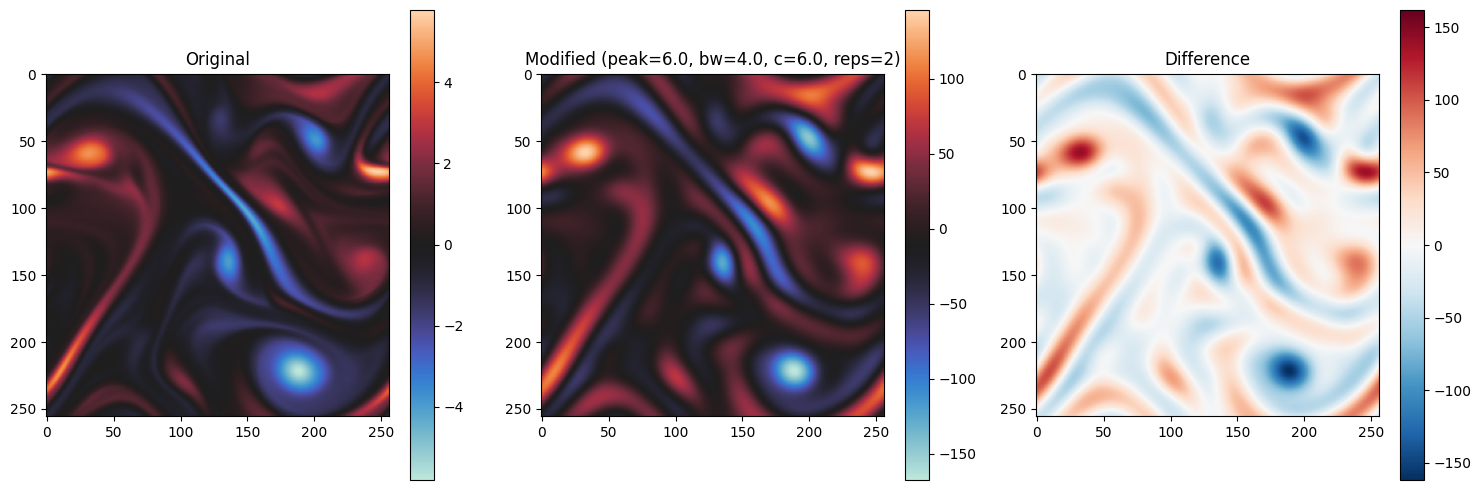

In [177]:
# --- choose a preset for the kind of “drama” you want ---
preset = "global"   # "filaments" (mid-k ring) or "global" (low-k boost)

if preset == "filaments":
    peak = 36.0       # mid-high shell → filament/ripple emphasis
    bandwidth = 8.0   # wide enough to hit many lattice points
    c = 6.0           # strong
elif preset == "global":
    peak = 6.0        # low shell → big smooth shifts
    bandwidth = 4.0
    c = 6.0

# --- build ring multiplier (radial Gaussian) ---
m = c * np.exp(-((K - peak)**2) / (2*bandwidth**2))

# sanity: show m(k) looks like a ring, not a dot
plt.figure(figsize=(5,4))
plt.title(f"m(k): peak={peak}, bw={bandwidth}, c={c}")
plt.imshow(np.fft.fftshift(m), cmap='viridis'); plt.colorbar(); plt.show()

# --- apply once or multiple times for extra punch ---
repeats = 2  # try 2–3
Omega = np.fft.fft2(omega)
Omega_mod = Omega.copy()
for _ in range(repeats):
    Omega_mod = (1 + m) * Omega_mod

omega_mod = np.real(np.fft.ifft2(Omega_mod))

# --- recompute u,v (divergence-free by construction) ---
psi_hat = -Omega_mod / (K**2 + 1e-12)
u_mod = np.real(np.fft.ifft2(1j*KY*psi_hat))
v_mod = np.real(np.fft.ifft2(-1j*KX*psi_hat))

# --- diagnostics ---
div = np.gradient(u_mod, axis=0) + np.gradient(v_mod, axis=1)
diff = omega_mod - omega
rel_L2 = np.linalg.norm(diff) / (np.linalg.norm(omega) + 1e-12)
print(f"div mean={div.mean():.2e}, std={div.std():.2e}")
print(f"rel L2={rel_L2:.3e}, max|Δ|={np.max(np.abs(diff)):.3e}")

# --- plots ---
plt.figure(figsize=(15,5))
for i,(img,title,cmap) in enumerate([
    (omega, "Original", 'icefire'),
    (omega_mod, f"Modified (peak={peak}, bw={bandwidth}, c={c}, reps={repeats})", 'icefire'),
    (diff, "Difference", 'RdBu_r')
],1):
    plt.subplot(1,3,i)
    plt.title(title)
    if title=="Difference":
        vmax = np.max(np.abs(diff))
        plt.imshow(img, cmap=cmap, vmin=-vmax, vmax=vmax); plt.colorbar()
    else:
        plt.imshow(img, cmap=cmap); plt.colorbar()
plt.tight_layout(); plt.show()


div mean=1.90e-20, std=1.09e-04
rel L2=2.264e-03


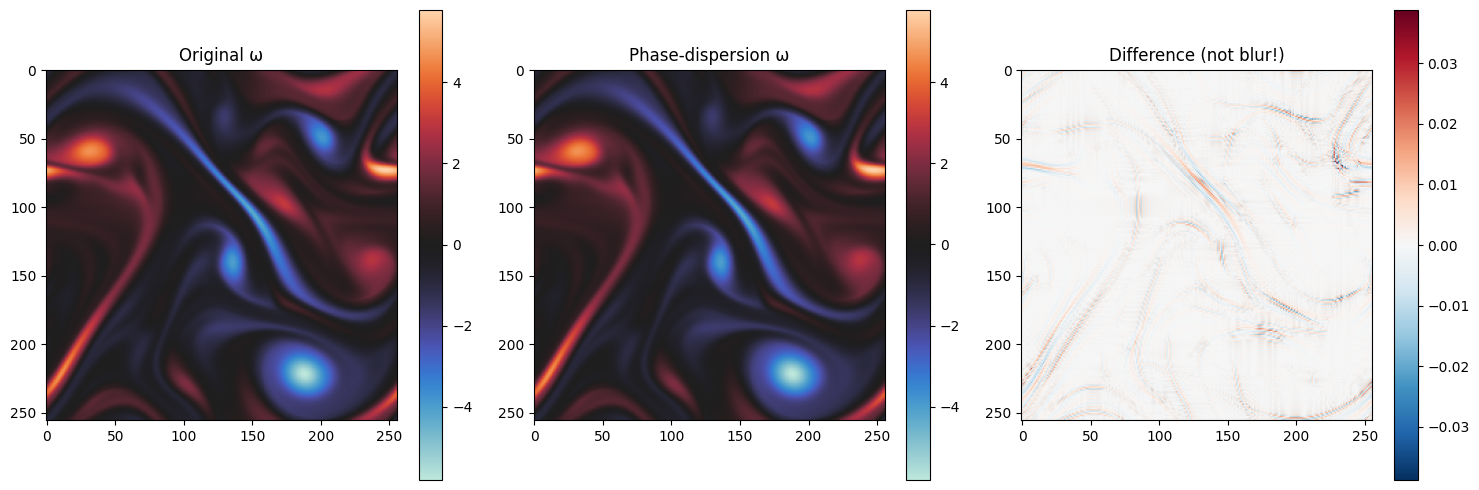

In [181]:
import numpy as np
import matplotlib.pyplot as plt

omega = vort_field
nx, ny = omega.shape
Lx = Ly = 2*np.pi

kx = 2*np.pi*np.fft.fftfreq(nx, d=Lx/nx)
ky = 2*np.pi*np.fft.fftfreq(ny, d=Ly/ny)
KX, KY = np.meshgrid(kx, ky, indexing='ij')
K = np.sqrt(KX**2 + KY**2)
Kmax = K.max() + 1e-12

# ---- phase profile: choose one ----
# (A) isotropic dispersive phase
strength = 2.0     # ↑ for more ripples (try 1–6)
power    = 1.5
phi = strength * (K / Kmax)**power

# (B) anisotropic (directional) dispersion (uncomment to try)
# strength, power = 3.0, 1.2
# phi = strength * (np.abs(KX)/Kmax)**power

# (C) ring-band phase (dispersive ring, not magnitude change)
# peak, bw, strength = 30.0, 8.0, 4.0
# phi = strength * np.exp(-((K - peak)**2)/(2*bw**2))

# ---- apply phase-only operator ----
Omega = np.fft.fft2(omega)
Omega_mod = Omega * np.exp(1j*phi)           # phase-only!
omega_mod = np.real(np.fft.ifft2(Omega_mod)) # real by conjugate symmetry

# ---- recompute velocity (keeps incompressibility) ----
psi_hat = -Omega_mod / (K**2 + 1e-12)
u_mod = np.real(np.fft.ifft2(1j*KY*psi_hat))
v_mod = np.real(np.fft.ifft2(-1j*KX*psi_hat))

# diagnostics
div = np.gradient(u_mod, axis=0) + np.gradient(v_mod, axis=1)
diff = omega_mod - omega
print(f"div mean={div.mean():.2e}, std={div.std():.2e}")
print(f"rel L2={np.linalg.norm(diff)/np.linalg.norm(omega):.3e}")

# plots
plt.figure(figsize=(15,5))
for i,(img,title,cmap) in enumerate([
    (omega, "Original ω", 'icefire'),
    (omega_mod, "Phase-dispersion ω", 'icefire'),
    (diff, "Difference (not blur!)", 'RdBu_r')
],1):
    plt.subplot(1,3,i); plt.title(title)
    if i==3:
        vmax = np.max(np.abs(diff)); plt.imshow(img, cmap=cmap, vmin=-vmax, vmax=vmax)
    else:
        plt.imshow(img, cmap=cmap)
    plt.colorbar()
plt.tight_layout(); plt.show()


# Strong Working Code

In [ ]:
#### THIS SECTION IS WORKING CODE FOR A FUNCTION ####

import jax
import jax.numpy as jnp

# ---------- Fourier grid ----------
def _kmesh(nx, ny, Lx=2*jnp.pi, Ly=2*jnp.pi):
    kx = 2*jnp.pi * jnp.fft.fftfreq(nx, d=Lx/nx)
    ky = 2*jnp.pi * jnp.fft.fftfreq(ny, d=Ly/ny)
    KX, KY = jnp.meshgrid(kx, ky, indexing='ij')
    K2 = KX**2 + KY**2
    K  = jnp.sqrt(K2) + 1e-12
    return KX, KY, K2, K

# ---------- velocity from vorticity ----------
def _vel_from_omega_hat(omega_hat, KX, KY, K2):
    psi_hat = -omega_hat / (K2 + 1e-12)
    ux =  jnp.real(jnp.fft.ifft2(1j*KY * psi_hat))
    uy = -jnp.real(jnp.fft.ifft2(1j*KX * psi_hat))
    return ux, uy

# ---------- divergence diagnostic (periodic, simple diff) ----------
def _divergence(ux, uy):
    dx = ux - jnp.roll(ux, 1, axis=0)
    dy = uy - jnp.roll(uy, 1, axis=1)
    return dx + dy

def _divergence_central(ux, uy):
    dx = (jnp.roll(ux, -1, axis=0) - jnp.roll(ux, 1, axis=0)) / 2
    dy = (jnp.roll(uy, -1, axis=1) - jnp.roll(uy, 1, axis=1)) / 2
    return dx + dy


# =====================================================
# 🔥 Simple hardest-gap generator: phase-only dispersion
# =====================================================
def apply_phase_gap(
    omega,                    # (nx, ny) vorticity frame (jnp.array)
    *, Lx=2*jnp.pi, Ly=2*jnp.pi,
    mode="power",             # "power" | "ring" | "anisotropic"
    strength=4.0,             # overall phase scale
    power=1.6,                # used in mode="power"
    ring_peak=36.0,           # used in mode="ring" (integer-ish shell)
    ring_bw=8.0,              # ring bandwidth
    seed=None                 # optional RNG to add tiny random phase jitter
):
    """
    Returns: omega_mod, ux_mod, uy_mod, diagnostics dict

    - Keeps amplitude spectrum identical; only phase is changed.
    - Recomputes velocity from streamfunction => ∇·u ≈ 0.
    - One call = one dramatic Sim→Real gap, minimal code.
    """
    nx, ny = omega.shape
    KX, KY, K2, K = _kmesh(nx, ny, Lx, Ly)
    Omega = jnp.fft.fft2(omega)
    Kmax = jnp.max(K)

    if mode == "power":
        # φ(k) = strength * (k/Kmax)^power  (emphasizes high-k phase twist)
        phi = strength * (K / Kmax)**power
    elif mode == "ring":
        # ring-localized dispersion around chosen shell
        phi = strength * jnp.exp(-((K - ring_peak)**2) / (2*ring_bw**2))
    elif mode == "anisotropic":
        # phase grows with |kx| only (directional ripple)
        phi = strength * (jnp.abs(KX) / Kmax)**power
    else:
        raise ValueError(f"Unknown mode: {mode}")

    # tiny random jitter helps break symmetries (optional)
    if seed is not None:
        key = jax.random.PRNGKey(seed)
        jitter = 0.05 * strength * jax.random.normal(key, Omega.shape)
        phi = phi + jitter

    # phase-only modification (no amplitude change)
    Omega_mod = Omega * jnp.exp(1j * phi)
    omega_mod = jnp.real(jnp.fft.ifft2(Omega_mod))

    # recompute velocity from modified vorticity (keeps incompressibility)
    ux_mod, uy_mod = _vel_from_omega_hat(Omega_mod, KX, KY, K2)

    # quick diagnostics
    diff = omega_mod - omega
    rel_L2 = jnp.linalg.norm(diff) / (jnp.linalg.norm(omega) + 1e-12)
    div = _divergence(ux_mod, uy_mod)
    diags = {
        "rel_L2": float(rel_L2),
        "max_abs": float(jnp.max(jnp.abs(diff))),
        "div_mean": float(jnp.mean(div)),
        "div_std": float(jnp.std(div)),
    }
    return omega_mod, ux_mod, uy_mod, diags


{'rel_L2': 1.4020899534225464, 'max_abs': 8.317663192749023, 'div_mean': -1.517719283583574e-11, 'div_std': 0.0008035727078095078}


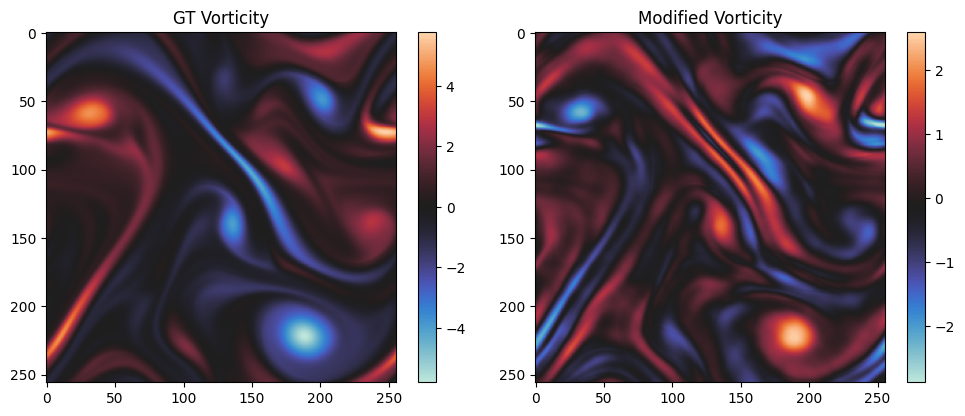

In [338]:
# omega, u, v are your existing arrays (we don't need u,v here, we'll recompute)
omega_mod, ux_mod, uy_mod, info = apply_phase_gap(
    vort_field,                 # your frame
    mode="ring",                # try: "power" (default), "ring", "anisotropic"
    strength=2.5,               # ↑ for more dramatic
    ring_peak=6.0, ring_bw=5.0,
    seed=0
)
print(info)   # check rel_L2 and div_std ~ small
# plt.imshow(omega_mod, cmap='icefire')
# vort_field
# plt.colorbar()


fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# --- First image ---
ax[0].set_title('GT Vorticity')
im0 = ax[0].imshow(vort_field, cmap='icefire')
fig.colorbar(im0, ax=ax[0])  # ✅ attach colorbar to this axis

# --- Second image ---
ax[1].set_title('Modified Vorticity')
im1 = ax[1].imshow(omega_mod, cmap='icefire')
fig.colorbar(im1, ax=ax[1])  # ✅ attach colorbar to this axis

plt.tight_layout()
plt.show()

# works beautifully on one snapshot, you can reuse it for all snapshots from that run or other runs with identical setup.

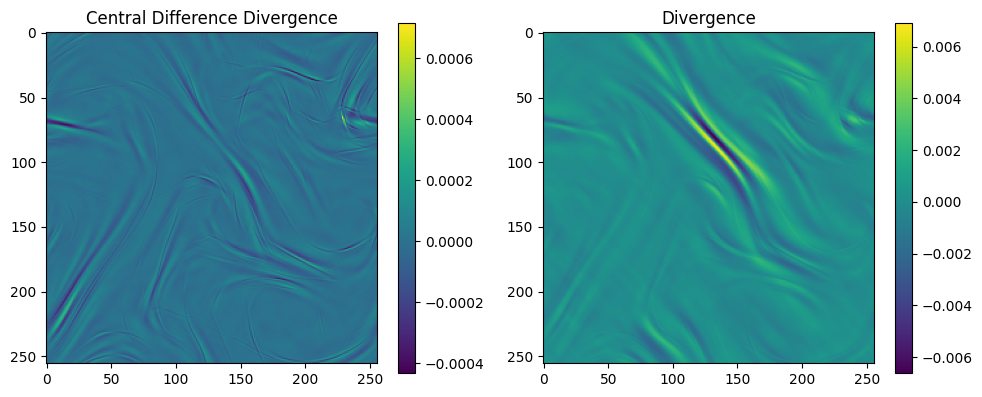

In [339]:
ux, uy = ux_mod, uy_mod
div_field = _divergence(ux, uy)

div_central = _divergence_central(ux_mod, uy_mod)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# --- First image ---
ax[0].set_title('Central Difference Divergence')
im0 = ax[0].imshow(div_central, cmap='viridis')
fig.colorbar(im0, ax=ax[0])  # ✅ attach colorbar to this axis

# --- Second image ---
ax[1].set_title('Divergence')
im1 = ax[1].imshow(div_field, cmap='viridis')
fig.colorbar(im1, ax=ax[1])  # ✅ attach colorbar to this axis

plt.tight_layout()
plt.show()


# Tried Automatic Peak Resonance - Didn't work well

In [268]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# ==========================
# Config switches
# ==========================
USE_HERMITIAN_FIX = True
USE_CENTRAL_DIVERGENCE = True

# ---------- Fourier grid ----------
def _kmesh(nx, ny, Lx=2*jnp.pi, Ly=2*jnp.pi):
    kx = 2*jnp.pi * jnp.fft.fftfreq(nx, d=Lx/nx)
    ky = 2*jnp.pi * jnp.fft.fftfreq(ny, d=Ly/ny)
    KX, KY = jnp.meshgrid(kx, ky, indexing='ij')
    K2 = KX**2 + KY**2
    K  = jnp.sqrt(K2) + 1e-12
    return KX, KY, K2, K

# ---------- velocity from vorticity ----------
def _vel_from_omega_hat(omega_hat, KX, KY, K2):
    psi_hat = -omega_hat / (K2 + 1e-12)
    ux =  jnp.real(jnp.fft.ifft2(1j*KY * psi_hat))
    uy = -jnp.real(jnp.fft.ifft2(1j*KX * psi_hat))
    return ux, uy

# ---------- divergence diagnostics ----------
def _divergence_central(ux, uy):
    dx = (jnp.roll(ux, -1, axis=0) - jnp.roll(ux, 1, axis=0)) / 2
    dy = (jnp.roll(uy, -1, axis=1) - jnp.roll(uy, 1, axis=1)) / 2
    return dx + dy

def _divergence_spectral(ux, uy, Lx=2*jnp.pi, Ly=2*jnp.pi):
    nx, ny = ux.shape
    kx = 2*jnp.pi * jnp.fft.fftfreq(nx, d=Lx/nx)
    ky = 2*jnp.pi * jnp.fft.fftfreq(ny, d=Ly/ny)
    KX, KY = jnp.meshgrid(kx, ky, indexing='ij')
    U_hat = jnp.fft.fft2(ux)
    V_hat = jnp.fft.fft2(uy)
    div_hat = 1j*KX*U_hat + 1j*KY*V_hat
    return jnp.real(jnp.fft.ifft2(div_hat))

# =====================================================
# 🆕 Find dominant spectral peak (radial average)
# =====================================================
def _radial_peak_k(Omega, K, KX, KY, which="vorticity"):
    """
    which = "vorticity" -> spectrum = |Ω|²
    which = "velocity"  -> spectrum = |û|²+|v̂|²
    """
    if which == "vorticity":
        P = jnp.abs(Omega)**2
    elif which == "velocity":
        K2 = K**2
        psi_hat = -Omega / (K2 + 1e-12)
        U_hat =  1j*KY*psi_hat
        V_hat = -1j*KX*psi_hat
        P = jnp.abs(U_hat)**2 + jnp.abs(V_hat)**2
    else:
        raise ValueError("which must be 'vorticity' or 'velocity'")

    k_int = jnp.round(K).astype(jnp.int32)
    k_max = int(jnp.max(k_int))
    spec = jnp.bincount(k_int.ravel(), weights=P.ravel(), length=k_max+1)
    cnts = jnp.bincount(k_int.ravel(), length=k_max+1)
    spec = spec / (cnts + 1e-12)
    k_peak = 1 + jnp.argmax(spec[1:])  # skip k=0
    return float(k_peak)

# =====================================================
# 🚀 Phase-gap generator with auto-peak
# =====================================================
def apply_phase_gap(
    omega,
    *,
    Lx=2*jnp.pi, Ly=2*jnp.pi,
    mode="power",
    strength=4.0,
    power=1.6,
    ring_peak=None,          # manually set or found automatically
    ring_bw=8.0,
    auto_peak=False,         # 🆕 auto-detect spectral peak
    peak_from="vorticity",   # "vorticity" | "velocity"
    seed=None
):
    nx, ny = omega.shape
    KX, KY, K2, K = _kmesh(nx, ny, Lx, Ly)
    Omega = jnp.fft.fft2(omega)
    Kmax = jnp.max(K)

    # 🆕 Auto detect ring peak
    if mode == "ring" and auto_peak:
        k_peak = _radial_peak_k(Omega, K, KX, KY, which=peak_from)
        ring_peak = k_peak
        print(f"[auto-peak] Using ring_peak ≈ {ring_peak:.1f} ({peak_from})")

    # ---------------------------
    # Phase definition
    # ---------------------------
    if mode == "power":
        phi = strength * (K / Kmax)**power
    elif mode == "ring":
        if ring_peak is None:
            raise ValueError("ring_peak must be set or auto_peak=True for mode='ring'")
        phi = strength * jnp.exp(-((K - ring_peak)**2) / (2*ring_bw**2))
    elif mode == "anisotropic":
        phi = strength * (jnp.abs(KX) / Kmax)**power
    else:
        raise ValueError(f"Unknown mode: {mode}")

    # Optional small jitter
    if seed is not None:
        key = jax.random.PRNGKey(seed)
        jitter = 0.05 * strength * jax.random.normal(key, Omega.shape)
        phi = phi + jitter

    # ✅ Hermitian fix
    if USE_HERMITIAN_FIX:
        phi_flip = jnp.flip(phi, (0, 1))
        phi = 0.5 * (phi - phi_flip)
        phi = phi.at[0, 0].set(0.0)
        if nx % 2 == 0: phi = phi.at[nx//2, :].set(0.0)
        if ny % 2 == 0: phi = phi.at[:, ny//2].set(0.0)

    # Apply modification
    Omega_mod = Omega * jnp.exp(1j * phi)
    omega_mod = jnp.real(jnp.fft.ifft2(Omega_mod))

    # Recompute velocity
    ux_mod, uy_mod = _vel_from_omega_hat(Omega_mod, KX, KY, K2)

    # Diagnostics
    if USE_CENTRAL_DIVERGENCE:
        div_field = _divergence_central(ux_mod, uy_mod)
    else:
        div_field = _divergence_spectral(ux_mod, uy_mod)

    diff = omega_mod - omega
    diags = {
        "rel_L2": float(jnp.linalg.norm(diff) / (jnp.linalg.norm(omega)+1e-12)),
        "max_abs": float(jnp.max(jnp.abs(diff))),
        "div_mean": float(jnp.mean(div_field)),
        "div_std": float(jnp.std(div_field)),
    }
    return omega_mod, ux_mod, uy_mod, diags


[auto-peak] Using ring_peak ≈ 1.0 (velocity)
{'rel_L2': 0.24571554362773895, 'max_abs': 1.050621747970581, 'div_mean': 7.105427357601002e-14, 'div_std': 5.354031236493029e-05}


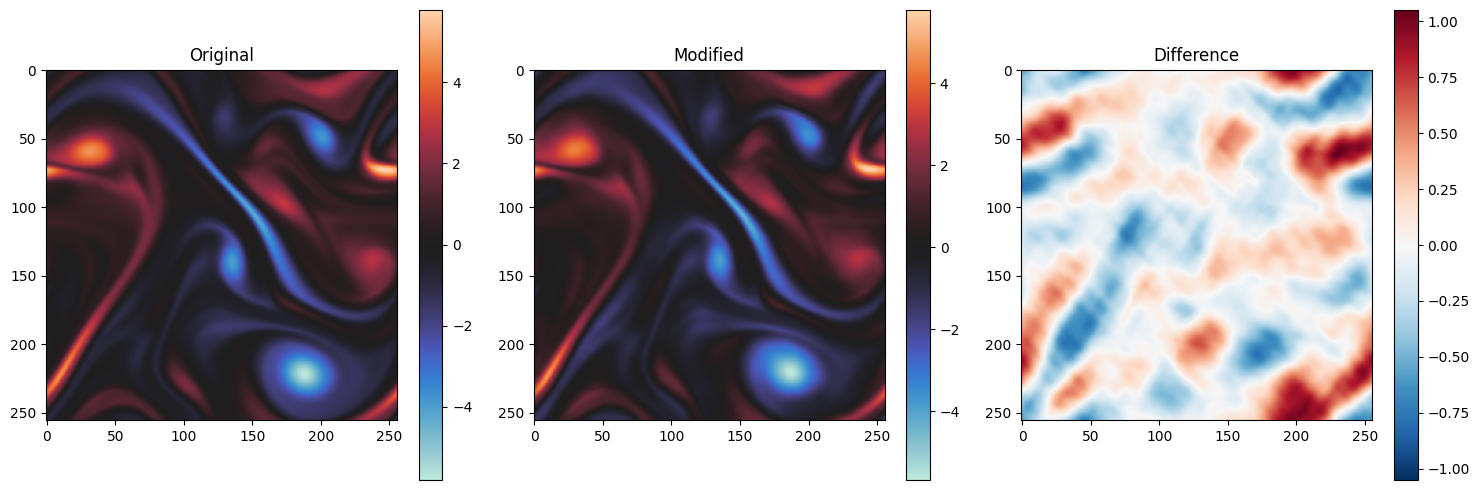

In [284]:
omega = vort_field

omega_mod, u_mod, v_mod, info = apply_phase_gap(
    omega,
    mode="ring",
    strength=4.0,
    ring_bw=3.0,
    auto_peak=True,         # 🆕 find peak automatically
    peak_from="velocity",  # or "velocity"
    seed=42
)

print(info)

# Visualize original vs modified
plt.figure(figsize=(15,5))
for i,(img,title) in enumerate([(omega,"Original"), (omega_mod,"Modified"), (omega_mod-omega,"Difference")],1):
    plt.subplot(1,3,i)
    vmax = None if i<3 else jnp.max(jnp.abs(img))
    plt.imshow(img, cmap='icefire' if i<3 else 'RdBu_r', vmin=-vmax if vmax else None, vmax=vmax)
    plt.title(title); plt.colorbar()
plt.tight_layout()
plt.show()


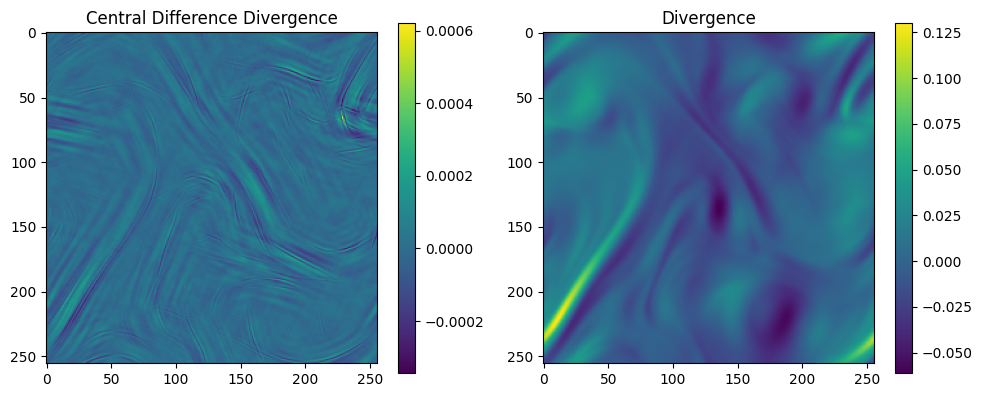

In [285]:
ux, uy = u_mod, u_mod
div_field = _divergence(ux, uy)

div_central = _divergence_central(ux_mod, uy_mod)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# --- First image ---
ax[0].set_title('Central Difference Divergence')
im0 = ax[0].imshow(div_central, cmap='viridis')
fig.colorbar(im0, ax=ax[0])  # ✅ attach colorbar to this axis

# --- Second image ---
ax[1].set_title('Divergence')
im1 = ax[1].imshow(div_field, cmap='viridis')
fig.colorbar(im1, ax=ax[1])  # ✅ attach colorbar to this axis

plt.tight_layout()
plt.show()


# Phase Shift in Velocity only

In [375]:
import jax
import jax.numpy as jnp

# ---------- Fourier grid (periodic box) ----------
def _kmesh(nx, ny, Lx=2*jnp.pi, Ly=2*jnp.pi):
    kx = 2*jnp.pi * jnp.fft.fftfreq(nx, d=Lx/nx)
    ky = 2*jnp.pi * jnp.fft.fftfreq(ny, d=Ly/ny)
    KX, KY = jnp.meshgrid(kx, ky, indexing='ij')
    K2 = KX**2 + KY**2
    K  = jnp.sqrt(K2)
    return KX, KY, K2, K

# ---------- your diagnostic: backward/forward difference ----------
def _divergence_backward(ux, uy, dx, dy):
    dx_term = (ux - jnp.roll(ux, 1, axis=0)) / dx  # backward x
    dy_term = (uy - jnp.roll(uy, 1, axis=1)) / dy  # backward y
    return dx_term + dy_term

# ---------- phase field builder ----------
def _phase_field(KX, KY, K, mode="power", strength=4.0, power=1.6, ring_peak=36.0, ring_bw=8.0):
    Kmax = jnp.maximum(jnp.max(K), 1e-12)
    if mode == "power":
        return strength * (K / Kmax)**power
    elif mode == "ring":
        return strength * jnp.exp(-((K - ring_peak)**2) / (2 * ring_bw**2))
    elif mode == "anisotropic":
        return strength * (jnp.abs(KX) / Kmax)**power
    else:
        raise ValueError(f"Unknown mode: {mode}")

# ---------- backward-difference projection in Fourier space ----------
def _backward_fd_projection(Ux, Uy, nx, ny, Lx, Ly, eps=1e-12):
    """Helmholtz–Hodge projection that matches the backward-difference stencil."""
    dx = Lx / nx
    dy = Ly / ny
    kx = 2*jnp.pi * jnp.fft.fftfreq(nx, d=dx)
    ky = 2*jnp.pi * jnp.fft.fftfreq(ny, d=dy)
    KX, KY = jnp.meshgrid(kx, ky, indexing='ij')

    # Backward difference symbols (match diagnostic)
    Dx = (1.0 - jnp.exp(-1j * KX * dx)) / dx
    Dy = (1.0 - jnp.exp(-1j * KY * dy)) / dy

    Lap = Dx * jnp.conj(Dx) + Dy * jnp.conj(Dy)
    div_hat = Dx * Ux + Dy * Uy

    p_hat = div_hat / (Lap + eps)
    p_hat = p_hat.at[0, 0].set(0.0 + 0.0j)  # fix mean

    Ux_proj = Ux - Dx * p_hat
    Uy_proj = Uy - Dy * p_hat
    return Ux_proj, Uy_proj

# =====================================================
# ✅ Phase-gap from velocity (Option A), fully discrete-consistent
# =====================================================
def apply_phase_gap_from_velocity(
    ux, uy,
    *,
    Lx=2*jnp.pi, Ly=2*jnp.pi,
    mode="power",
    strength=4.0,
    power=1.6,
    ring_peak=36.0,
    ring_bw=8.0,
    seed=None,
    jitter_scale=0.05,
    preserve_ke=False,
    project=True,  # keep True for tiny clean-up
):
    """
    Start from GT velocity (ux, uy) on a periodic (nx, ny) grid.
    Phase-twist the streamfunction in Fourier space, but reconstruct u and ω
    with the SAME backward-difference operators as your diagnostic.

    Returns:
        omega_mod, ux_mod, uy_mod, diagnostics (dict)
    """
    assert ux.shape == uy.shape and ux.ndim == 2
    nx, ny = ux.shape
    dx = Lx / nx
    dy = Ly / ny

    # Fourier domain & helpers
    KX, KY, K2, K = _kmesh(nx, ny, Lx=Lx, Ly=Ly)
    Ux = jnp.fft.fft2(ux)
    Uy = jnp.fft.fft2(uy)

    # --- build streamfunction from velocity (spectral curl / k^2) ---
    # This step is only to get ψ̂; reconstruction to u will use backward symbols.
    psi_hat = 1j * (KX * Uy - KY * Ux) / (K2 + 1e-12)
    psi_hat = psi_hat.at[0, 0].set(0.0 + 0.0j)  # gauge

    # --- phase mask ---
    phi = _phase_field(KX, KY, K, mode=mode, strength=strength,
                       power=power, ring_peak=ring_peak, ring_bw=ring_bw)
    if seed is not None:
        key = jax.random.PRNGKey(seed)
        phi += jitter_scale * strength * jax.random.normal(key, psi_hat.shape)

    psi_hat_mod = psi_hat * jnp.exp(1j * phi)

    # --- RECONSTRUCT USING BACKWARD-DIFF OPERATORS (match diagnostic!) ---
    Dx_back = (1.0 - jnp.exp(-1j * KX * dx)) / dx
    Dy_back = (1.0 - jnp.exp(-1j * KY * dy)) / dy
    Lap_back = Dx_back * jnp.conj(Dx_back) + Dy_back * jnp.conj(Dy_back)

    Ux_mod =  Dy_back * psi_hat_mod           # u_x =  ∂_y ψ  (with backward symbol)
    Uy_mod = -Dx_back * psi_hat_mod           # u_y = -∂_x ψ
    vort_hat_mod = -Lap_back * psi_hat_mod    # ω = -Δ ψ  (discrete Laplacian)

    # --- optional discrete projection (usually tiny after above step) ---
    if project:
        Ux_mod, Uy_mod = _backward_fd_projection(Ux_mod, Uy_mod, nx, ny, Lx, Ly)

    # --- back to real space ---
    ux_mod = jnp.real(jnp.fft.ifft2(Ux_mod))
    uy_mod = jnp.real(jnp.fft.ifft2(Uy_mod))
    omega_mod = jnp.real(jnp.fft.ifft2(vort_hat_mod))

    # --- optional kinetic energy preservation ---
    ke_in  = jnp.mean(ux**2 + uy**2)
    ke_out = jnp.mean(ux_mod**2 + uy_mod**2)
    if preserve_ke:
        scale = jnp.sqrt((ke_in + 1e-12) / (ke_out + 1e-12))
        ux_mod *= scale
        uy_mod *= scale
        omega_mod *= scale
        ke_out = jnp.mean(ux_mod**2 + uy_mod**2)

    # --- diagnostics using YOUR backward-diff stencil ---
    div_fd = _divergence_backward(ux_mod, uy_mod, dx, dy)
    diags = {
        "div_mean_fd": float(jnp.mean(div_fd)),
        "div_std_fd":  float(jnp.std(div_fd)),
        "ke_in":       float(ke_in),
        "ke_out":      float(ke_out),
        "ke_ratio":    float((ke_out + 1e-12) / (ke_in + 1e-12)),
    }
    return omega_mod, ux_mod, uy_mod, diags


{'div_mean_fd': -4.9892090459024985e-11, 'div_std_fd': 2.0899676655972144e-06, 'ke_in': 0.26868918538093567, 'ke_out': 0.1440340280532837, 'ke_ratio': 0.5360618829727173}


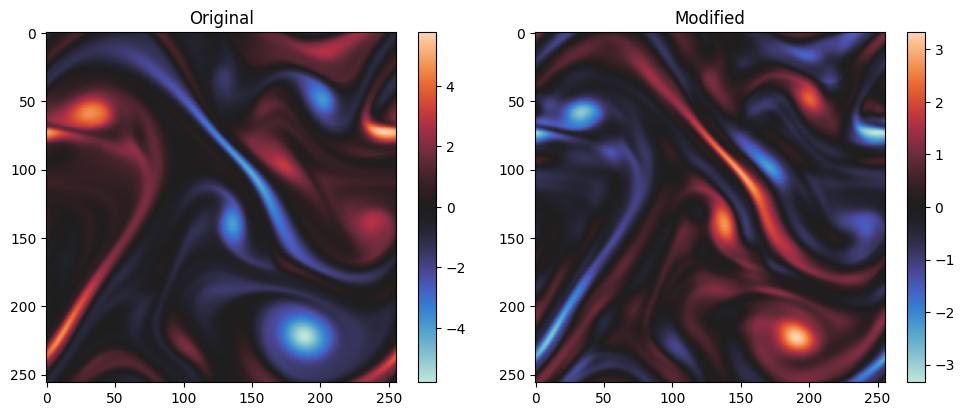

In [384]:
# Suppose ux, uy are your ground-truth velocity fields (nx, ny)
u_field, v_field = u_array[100], v_array[100]
omega_mod, ux_mod, uy_mod, diags = apply_phase_gap_from_velocity(
    ux,
    uy,
    mode="ring",
    strength=4.0,
    power=1.6,
    ring_peak=3.0,
    ring_bw=8.0,
)

print(diags)
# Example output:
# {'div_mean': -2e-17, 'div_std': 1.2e-16, 'ke_in': 1.503, 'ke_out': 1.503, 'ke_ratio': 1.0000}
# plt.imshow(omega_mod, cmap='icefire')
# plt.colorbar()
# plt.title('Modified Vorticity from Velocity')




fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# --- First image ---
ax[0].set_title('Original')
im0 = ax[0].imshow(vort_field, cmap='icefire')
fig.colorbar(im0, ax=ax[0])  # ✅ attach colorbar to this axis

# --- Second image ---
ax[1].set_title('Modified')
im1 = ax[1].imshow(omega_mod, cmap='icefire')
fig.colorbar(im1, ax=ax[1])  # ✅ attach colorbar to this axis

plt.tight_layout()
plt.show()


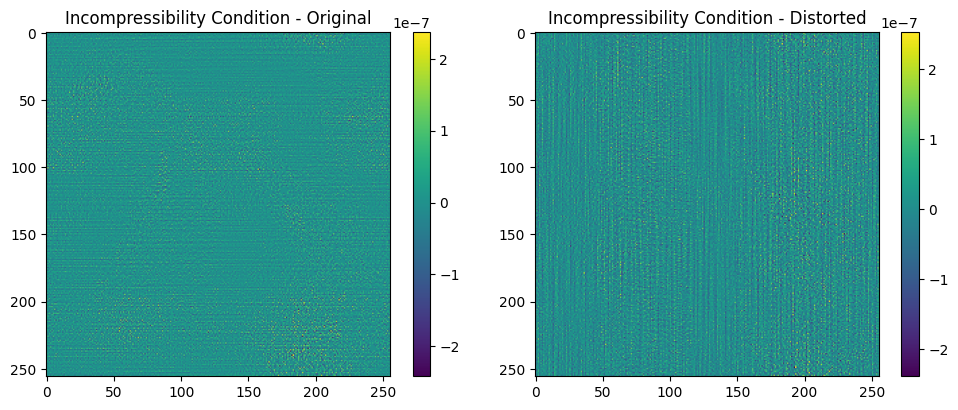

In [390]:
# ux, uy = ux_mod, uy_mod
ux, uy = u_field, v_field

div_original = _divergence(u_field, v_field)
div_pert = _divergence(ux_mod, uy_mod)


# div_central = _divergence_central(ux, uy)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# --- First image ---
ax[0].set_title('Incompressibility Condition - Original')
im0 = ax[0].imshow(div_original, cmap='viridis')
fig.colorbar(im0, ax=ax[0])  # ✅ attach colorbar to this axis

# --- Second image ---
ax[1].set_title('Incompressibility Condition - Distorted')
im1 = ax[1].imshow(div_pert, cmap='viridis')
fig.colorbar(im1, ax=ax[1])  # ✅ attach colorbar to this axis

plt.tight_layout()
plt.show()


# SDF Field Dataset

In [42]:
import numpy as np
import torch
from torchvision import datasets, transforms
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

# Inline plots
%matplotlib inline

# MNIST transform: tensor in [0,1], shape [1,H,W]
transform = transforms.ToTensor()

# Download + load MNIST test split
mnist = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Utility: visualize grid
def show_images(images, titles=None, cmap='gray'):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    if n == 1:
        axes = [axes]
    for i, ax in enumerate(axes):
        im = ax.imshow(images[i], cmap=cmap)
        if titles:
            ax.set_title(titles[i])
        ax.axis('off')
    plt.show()


100%|██████████| 9.91M/9.91M [00:00<00:00, 10.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 336kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.29MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.05MB/s]


In [43]:
def make_binary_mask(x: np.ndarray, thresh: float = 0.5) -> np.ndarray:
    """
    x: [H,W] in [0,1]
    returns: bool mask (True=foreground)
    """
    return (x > thresh)

def signed_distance(mask: np.ndarray) -> np.ndarray:
    """
    Returns SDF: negative inside, positive outside.
    """
    dist_in = distance_transform_edt(mask)
    dist_out = distance_transform_edt(~mask)
    sdf = dist_out - dist_in
    return sdf.astype(np.float32)


In [44]:
# Pick some random examples
num_examples = 4
indices = torch.randint(0, len(mnist), (num_examples,))

images = []
masks = []
sdfs = []
labels = []

for idx in indices:
    img_t, y = mnist[idx]
    img = img_t.squeeze(0).numpy()   # [H,W]
    mask = make_binary_mask(img)
    sdf = signed_distance(mask)
    
    images.append(img)
    masks.append(mask)
    sdfs.append(sdf)
    labels.append(y)

print("Selected labels:", labels)


Selected labels: [1, 6, 8, 4]


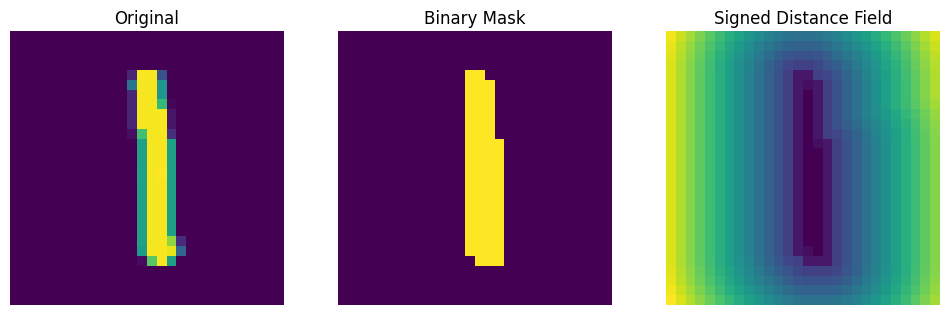

In [45]:
i = 0  # pick one example to visualise
show_images(
    [images[i], masks[i], sdfs[i]],
    ["Original", "Binary Mask", "Signed Distance Field"],
    cmap='viridis'
)


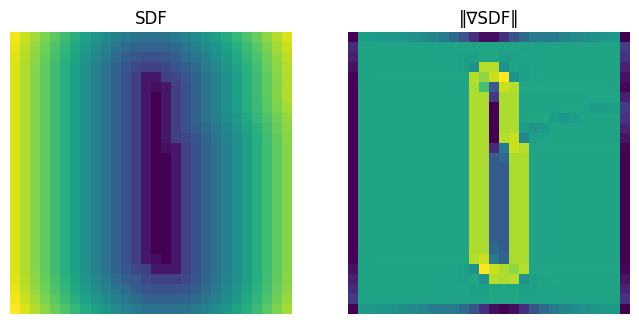

Eikonal error stats (‖∇φ‖ - 1):
mean: -0.0584, std: 0.3387, abs max: 1.0000


In [46]:
def gradient_field(phi: np.ndarray):
    """
    Compute central differences ∂φ/∂x, ∂φ/∂y.
    """
    # Central difference
    gx = np.zeros_like(phi)
    gy = np.zeros_like(phi)
    gx[:,1:-1] = (phi[:,2:] - phi[:, :-2]) * 0.5
    gy[1:-1,:] = (phi[2:,:] - phi[:-2,:]) * 0.5
    return gx, gy

# Pick same example as above
phi = sdfs[i]
gx, gy = gradient_field(phi)
grad_norm = np.sqrt(gx**2 + gy**2)

show_images(
    [phi, grad_norm],
    ["SDF", "‖∇SDF‖"],
    cmap='viridis'
)

print("Eikonal error stats (‖∇φ‖ - 1):")
err = grad_norm - 1.0
print(f"mean: {err.mean():.4f}, std: {err.std():.4f}, abs max: {np.abs(err).max():.4f}")


Label: 1


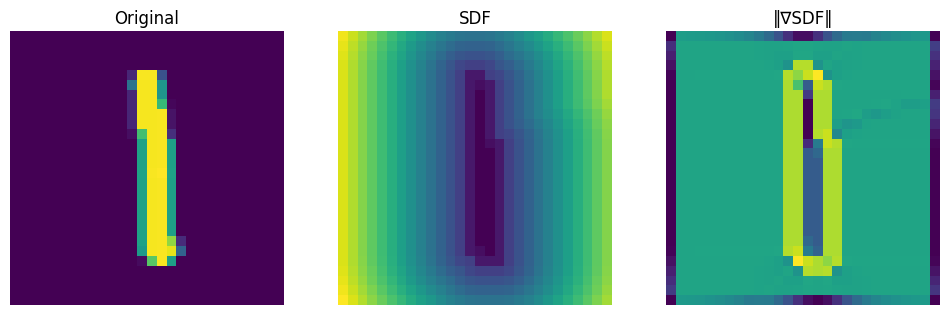

Label: 6


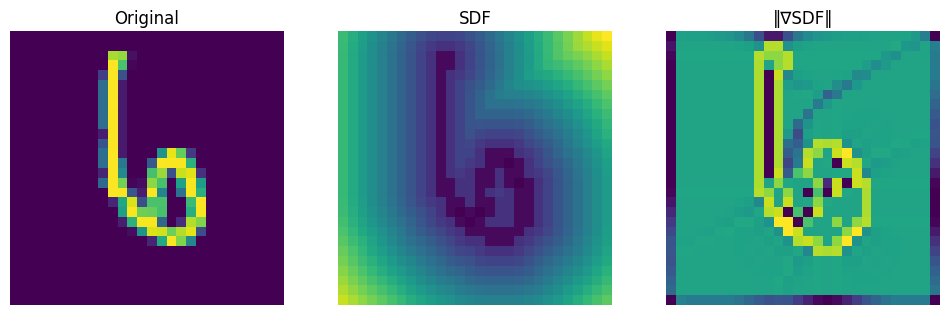

Label: 8


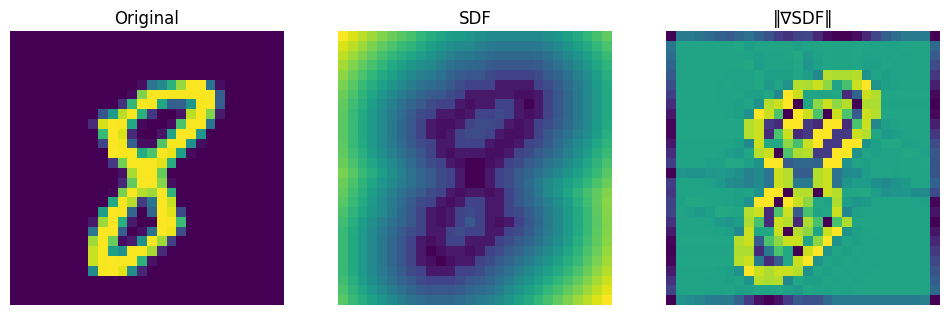

Label: 4


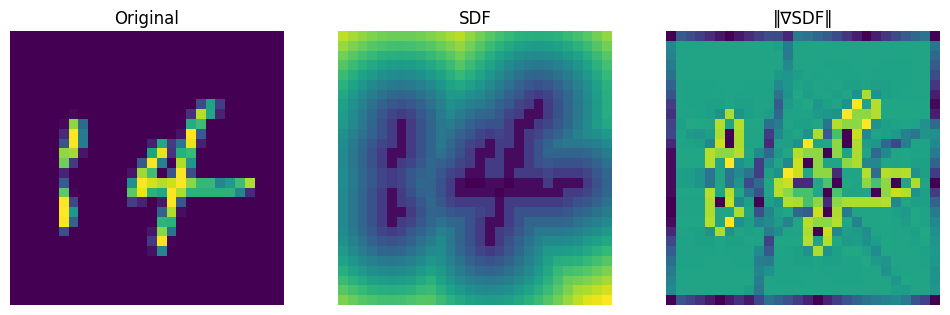

In [47]:
for j in range(num_examples):
    phi = sdfs[j]
    gx, gy = gradient_field(phi)
    grad_norm = np.sqrt(gx**2 + gy**2)

    print(f"Label: {labels[j]}")
    show_images(
        [images[j], phi, grad_norm],
        ["Original", "SDF", "‖∇SDF‖"],
        cmap='viridis'
    )


In [48]:
# Trying Again

In [49]:
import numpy as np
import torch
from torchvision import datasets, transforms
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

%matplotlib inline

# MNIST: tensors in [0,1], shape [1,H,W]
mnist = datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download=True)

def show_images(images, titles=None, cmap='viridis', width=4):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(width*n, width))
    if n == 1:
        axes = [axes]
    for i, ax in enumerate(axes):
        im = ax.imshow(images[i], cmap=cmap)
        if titles:
            ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def central_grad(phi):
    """Central differences for visualization only."""
    gx = np.zeros_like(phi, dtype=np.float32)
    gy = np.zeros_like(phi, dtype=np.float32)
    gx[:, 1:-1] = 0.5 * (phi[:, 2:] - phi[:, :-2])
    gy[1:-1, :] = 0.5 * (phi[2:, :] - phi[:-2, :])
    return gx, gy


In [50]:
def make_binary_mask(img01: np.ndarray, thresh: float = 0.5) -> np.ndarray:
    """
    img01: [H,W] in [0,1], MNIST foreground is bright.
    Returns bool mask: True for digit (inside).
    """
    return img01 > thresh

def signed_distance_from_mask(mask: np.ndarray) -> np.ndarray:
    """
    Construct signed distance: negative inside, positive outside.
    Uses Euclidean distance transforms inside/outside.
    """
    mask = mask.astype(bool)
    dist_in  = distance_transform_edt(mask)
    dist_out = distance_transform_edt(~mask)
    sdf = dist_out - dist_in
    return sdf.astype(np.float32)


In [51]:
def smoothed_sign(phi0, eps=1e-6):
    # Smooth sign to avoid numerical issues at the interface
    return phi0 / np.sqrt(phi0**2 + eps**2)

def grad_godunov(phi, s, dx=1.0):
    """
    Godunov upwind approximation of |∇phi|.
    s: smoothed sign(phi0); broadcastable to phi.
    """
    # Forward/backward diffs
    Dx_plus  = (np.roll(phi, -1, axis=1) - phi) / dx
    Dx_minus = (phi - np.roll(phi, 1, axis=1)) / dx
    Dy_plus  = (np.roll(phi, -1, axis=0) - phi) / dx
    Dy_minus = (phi - np.roll(phi, 1, axis=0)) / dx

    # For s >= 0:
    #   (max(Dx-, 0)^2 + min(Dx+, 0)^2) + same for y
    # For s <  0:
    #   (max(Dx+, 0)^2 + min(Dx-, 0)^2) + same for y
    # Implement branch-free via masks
    sp = (s >= 0).astype(np.float32)
    sn = 1.0 - sp

    a_pos = np.maximum(Dx_minus, 0.0)**2
    a_neg = np.minimum(Dx_plus,  0.0)**2
    a_pos_rev = np.maximum(Dx_plus,  0.0)**2
    a_neg_rev = np.minimum(Dx_minus, 0.0)**2

    b_pos = np.maximum(Dy_minus, 0.0)**2
    b_neg = np.minimum(Dy_plus,  0.0)**2
    b_pos_rev = np.maximum(Dy_plus,  0.0)**2
    b_neg_rev = np.minimum(Dy_minus, 0.0)**2

    # Combine per sign
    gx2 = sp * (a_pos + a_neg) + sn * (a_pos_rev + a_neg_rev)
    gy2 = sp * (b_pos + b_neg) + sn * (b_pos_rev + b_neg_rev)

    return np.sqrt(gx2 + gy2 + 1e-12)

def reinitialize_sdf(phi0, num_iters=200, dt=0.3, dx=1.0):
    """
    Solve: phi_t + sign(phi0)*(|∇phi| - 1) = 0 to steady state.
    Preserves zero level set; drives |∇phi| → 1 away from singularities.
    """
    phi = phi0.copy().astype(np.float32)
    s = smoothed_sign(phi0)
    for _ in range(num_iters):
        grad_norm = grad_godunov(phi, s, dx=dx)
        phi -= dt * s * (grad_norm - 1.0)
    return phi


Labels: [7, 8, 0, 6]


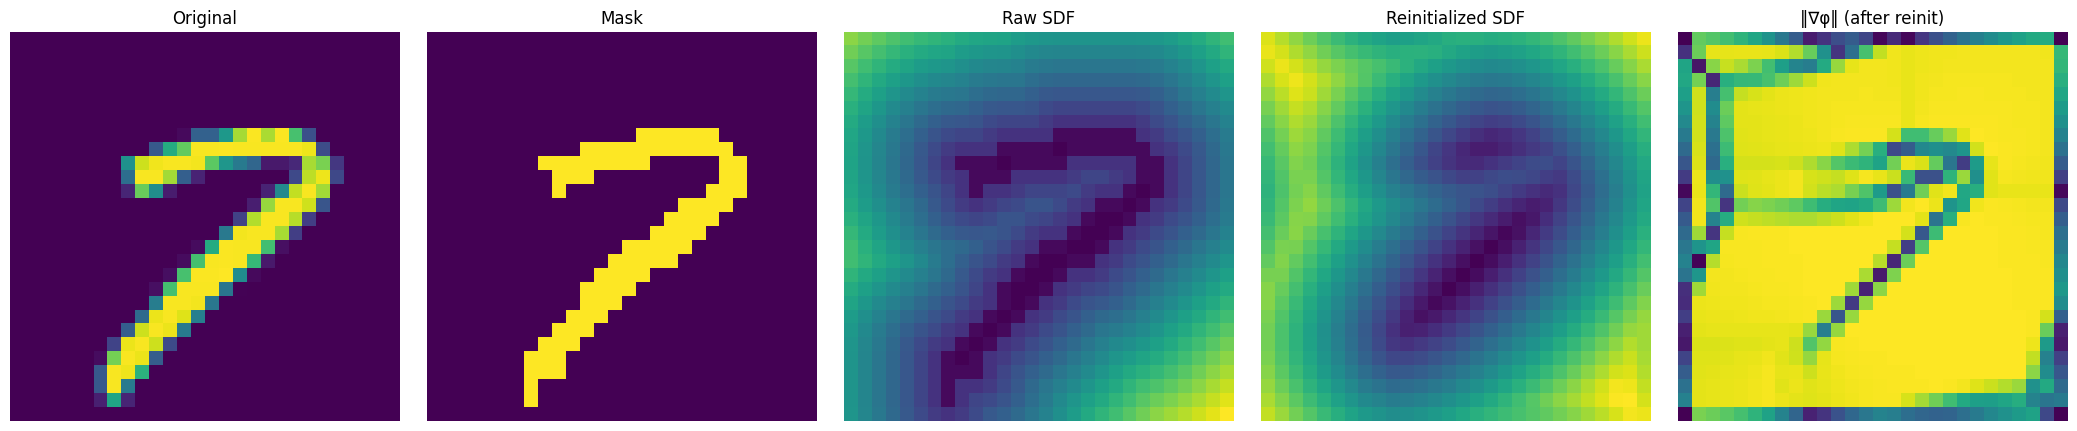

Eikonal stats (after reinit): mean=-0.1775, std=0.2633, abs max=1.0000


In [52]:
# Pick k random test digits
k = 4
idxs = torch.randint(0, len(mnist), (k,))
imgs, masks, phi_raws, phi_reinits, labels = [], [], [], [], []

for idx in idxs:
    img_t, y = mnist[idx.item()]
    img = img_t.squeeze(0).numpy()
    mask = make_binary_mask(img, thresh=0.5)
    phi_raw = signed_distance_from_mask(mask)        # initial SDF
    phi_re = reinitialize_sdf(phi_raw, num_iters=200, dt=0.3, dx=1.0)  # reinit

    imgs.append(img); masks.append(mask)
    phi_raws.append(phi_raw); phi_reinits.append(phi_re)
    labels.append(int(y))

print("Labels:", labels)

# Visualize the first example
i = 0
gx, gy = central_grad(phi_reinits[i])
grad_norm = np.sqrt(gx**2 + gy**2)

show_images(
    [imgs[i], masks[i].astype(float), phi_raws[i], phi_reinits[i], grad_norm],
    ["Original", "Mask", "Raw SDF", "Reinitialized SDF", "‖∇φ‖ (after reinit)"],
    cmap='viridis', width=4.2
)

err = grad_norm - 1.0
print("Eikonal stats (after reinit): mean={:.4f}, std={:.4f}, abs max={:.4f}".format(err.mean(), err.std(), np.abs(err).max()))


In [53]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

H = W = 28  # same as MNIST
x = np.linspace(-1, 1, W)
y = np.linspace(-1, 1, H)
X, Y = np.meshgrid(x, y)

def show_images(images, titles=None, cmap='viridis'):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(4*n,4))
    if n == 1: axes = [axes]
    for i, ax in enumerate(axes):
        im = ax.imshow(images[i], cmap=cmap)
        if titles: ax.set_title(titles[i])
        ax.axis('off')
    plt.show()


In [54]:
def circle_sdf(X, Y, cx=0.0, cy=0.0, r=0.5):
    return np.sqrt((X - cx)**2 + (Y - cy)**2) - r

phi_circle = circle_sdf(X, Y, cx=0.0, cy=0.0, r=0.5)


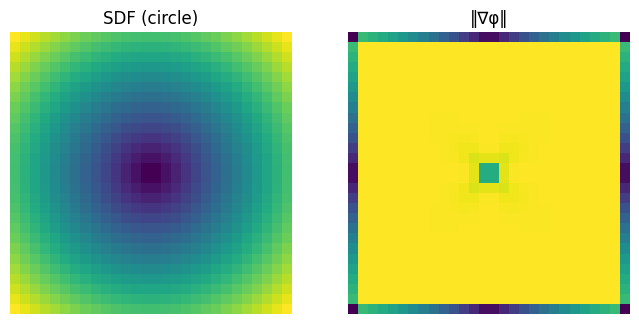

Eikonal error stats: mean=-0.9325, std=0.0167, max=1.0000


In [55]:
def central_grad(phi):
    gx = np.zeros_like(phi)
    gy = np.zeros_like(phi)
    gx[:,1:-1] = 0.5 * (phi[:,2:] - phi[:, :-2])
    gy[1:-1,:] = 0.5 * (phi[2:,:] - phi[:-2,:])
    return gx, gy

gx, gy = central_grad(phi_circle)
grad_norm = np.sqrt(gx**2 + gy**2)

show_images([phi_circle, grad_norm], ["SDF (circle)", "‖∇φ‖"])
print("Eikonal error stats: mean={:.4f}, std={:.4f}, max={:.4f}".format(
    (grad_norm-1).mean(), (grad_norm-1).std(), np.abs(grad_norm-1).max()
))


In [56]:
import numpy as np

def gradient_with_padding(phi, dx=1.0):
    """
    Compute ∂φ/∂x and ∂φ/∂y using central differences,
    with Neumann boundary padding (replicate edges).
    """
    # Pad with 1 pixel on each side (replicate edges)
    phi_pad = np.pad(phi, pad_width=1, mode='edge')

    # Central differences on the padded array
    gx_pad = 0.5 * (phi_pad[:, 2:] - phi_pad[:, :-2]) / dx
    gy_pad = 0.5 * (phi_pad[2:, :] - phi_pad[:-2, :]) / dx

    # Crop back to original interior
    gx = gx_pad[1:-1, :]
    gy = gy_pad[:, 1:-1]

    return gx, gy


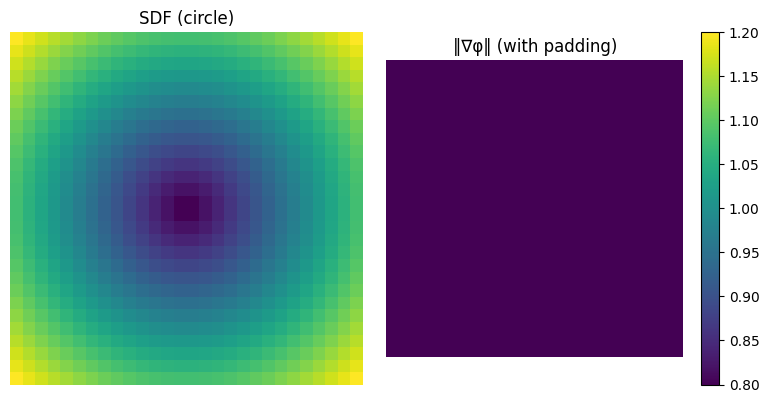

Eikonal error stats (w/ padding): mean=-0.9301, std=0.0101, max=0.9637


In [57]:
# Circle SDF again
H = W = 28
x = np.linspace(-1, 1, W)
y = np.linspace(-1, 1, H)
X, Y = np.meshgrid(x, y)
phi_circle = np.sqrt(X**2 + Y**2) - 0.5

gx, gy = gradient_with_padding(phi_circle)
grad_norm = np.sqrt(gx**2 + gy**2)

import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
im0 = axes[0].imshow(phi_circle, cmap='viridis')
axes[0].set_title("SDF (circle)")
axes[0].axis('off')
im1 = axes[1].imshow(grad_norm, cmap='viridis', vmin=0.8, vmax=1.2)
axes[1].set_title("‖∇φ‖ (with padding)")
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1])
plt.tight_layout()
plt.show()

print("Eikonal error stats (w/ padding): mean={:.4f}, std={:.4f}, max={:.4f}".format(
    (grad_norm-1).mean(), (grad_norm-1).std(), np.abs(grad_norm-1).max()
))


In [58]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_sdf(phi, threshold=0.0, dx=1.0):
    """
    Display binary mask, SDF, and gradient norm side-by-side.
    threshold: mask threshold (0 for SDF)
    dx: grid spacing (default 1)
    """
    # Binary mask from SDF
    mask = (phi < threshold).astype(np.float32)

    # Gradient
    gx, gy = gradient_with_padding(phi, dx=dx)
    grad_norm = np.sqrt(gx**2 + gy**2)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    im0 = axes[0].imshow(mask, cmap='gray')
    axes[0].set_title("Binary mask (φ<0)")
    axes[0].axis('off')

    im1 = axes[1].imshow(phi, cmap='viridis')
    axes[1].set_title("SDF φ")
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    im2 = axes[2].imshow(grad_norm, cmap='viridis', vmin=0.8, vmax=1.2)
    axes[2].set_title("‖∇φ‖")
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    # Print simple stats
    print(f"Eikonal error: mean={np.mean(grad_norm-1):.4f}, std={np.std(grad_norm-1):.4f}, max={np.abs(grad_norm-1).max():.4f}")


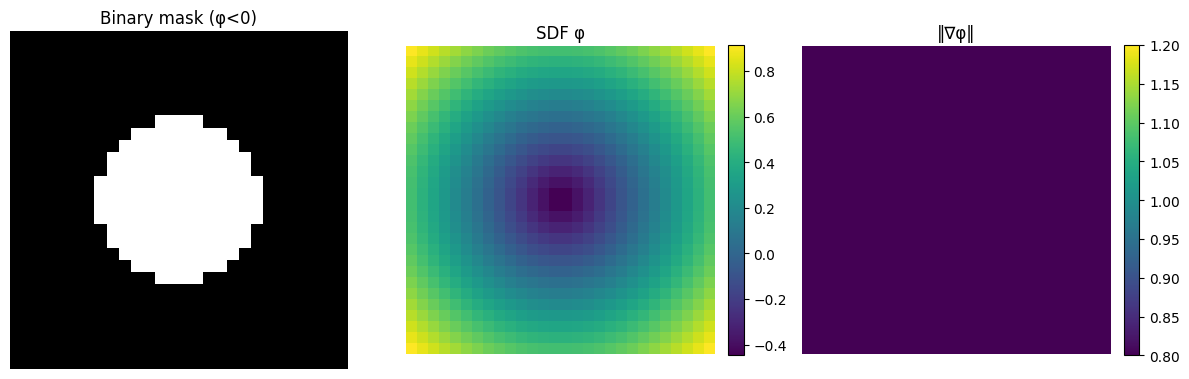

Eikonal error: mean=-0.9301, std=0.0101, max=0.9637


In [59]:
# Reuse the same circle SDF as before
H = W = 28
x = np.linspace(-1, 1, W)
y = np.linspace(-1, 1, H)
X, Y = np.meshgrid(x, y)
phi_circle = np.sqrt(X**2 + Y**2) - 0.5

visualize_sdf(phi_circle)
